In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# ==========================================
#  COMPLETE HEALTHCARE ANALYTICS PROJECT
#  Tasks 1 to 4 (FULL SOLUTION)
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, IsolationForest

# Output folder
OUT = "/kaggle/working/outputs"
os.makedirs(OUT, exist_ok=True)

# ==========================================
# LOAD DATASET
# ==========================================

df = pd.read_csv("/kaggle/input/health-care/healthcare_dataset.csv")

print("Dataset Loaded Successfully!")
print(df.head())

# ==========================================
# TASK 1 — EDA
# ==========================================

# AGE distribution
plt.figure(figsize=(8,6))
sns.histplot(df["Age"], bins=20)
plt.title("Age distribution")
plt.savefig(f"{OUT}/age_distribution.png")
plt.close()

# BILLING AMOUNT
plt.figure(figsize=(8,6))
sns.histplot(df["Billing Amount"], bins=20)
plt.title("Billing Amount Distribution")
plt.savefig(f"{OUT}/billing_distribution.png")
plt.close()

# ROOM NUMBER distribution
plt.figure(figsize=(8,6))
sns.histplot(df["Room Number"], bins=20)
plt.title("Room Number Distribution")
plt.savefig(f"{OUT}/roomnumber_distribution.png")
plt.close()

# Frequency plots
for col in ["Medical Condition", "Admission Type", "Medication"]:
    plt.figure(figsize=(10,6))
    df[col].value_counts().plot(kind="bar")
    plt.title(f"Frequency of {col}")
    plt.tight_layout()
    plt.savefig(f"{OUT}/freq_{col.replace(' ','_')}.png")
    plt.close()

print("Task 1 Completed — EDA files saved.")

# ==========================================
# TASK 2 — SUPERVISED LEARNING (Predict Test Results)
# ==========================================

df_ml = df.copy()

# Drop ID-like or leakage columns
drop_cols = ["Name","Date of Admission","Discharge Date"]
df_ml = df_ml.drop(columns=drop_cols)

# Encode categorical
label_encoders = {}
for col in df_ml.columns:
    if df_ml[col].dtype == 'object':
        le = LabelEncoder()
        df_ml[col] = le.fit_transform(df_ml[col])
        label_encoders[col] = le

# Features & Target
X = df_ml.drop(columns=["Test Results"])
y = df_ml["Test Results"]

# Label encode target
y = LabelEncoder().fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Save metrics
metrics_text = f"""
Accuracy: {accuracy_score(y_test, y_pred)}

Classification Report:
{classification_report(y_test, y_pred)}
"""

with open(f"{OUT}/model_metrics.txt", "w") as f:
    f.write(metrics_text)

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.savefig(f"{OUT}/confusion_matrix.png")
plt.close()

# Predicted vs Actual sample
pred_df = pd.DataFrame({
    "Actual": y_test[:50],
    "Predicted": y_pred[:50]
})
pred_df.to_csv(f"{OUT}/predicted_vs_actual_test_sample.csv", index=False)

print("Task 2 Completed — ML model trained & outputs saved.")

# ==========================================
# TASK 3 — UNSUPERVISED — Anomaly detection
# ==========================================

iso = IsolationForest(contamination=0.02, random_state=42)
df["Billing_Anomaly"] = iso.fit_predict(df[["Billing Amount"]])

anom_df = df[df["Billing_Anomaly"] == -1]
anom_df.to_csv(f"{OUT}/healthcare_anomalies.csv", index=False)

df.to_csv(f"{OUT}/healthcare_with_anomalies.csv", index=False)

print("Task 3 Completed — Anomalies detected.")

# ==========================================
# TASK 4 — AI DOCTOR RECOMMENDATION
# ==========================================

def ai_doctor_recommendation(age, med_condition, medication, predicted):
    predicted = str(predicted).lower()
    
    if "critical" in predicted:
        return (
            "Patient condition indicates a CRITICAL result. Immediate medical attention is required. "
            "Recommend urgent hospitalization, continuous monitoring and follow-up in 24 hours."
        )
    elif "abnormal" in predicted:
        return (
            "Test result is ABNORMAL. Further diagnostics and medication adjustments are recommended. "
            "Follow up within 3–5 days."
        )
    else:
        return (
            "Test result is NORMAL. Continue medication and routine follow-up. "
            "Maintain good diet, hydration and regular checkups."
        )

# Generate ONE sample output
sample = df.sample(1).iloc[0]

sample_pred = model.predict(
    df_ml.drop(columns=["Test Results"]).iloc[[0]]
)[0]

doctor_note = ai_doctor_recommendation(
    sample["Age"],
    sample["Medical Condition"],
    sample["Medication"],
    sample_pred
)

with open(f"{OUT}/doctor_sample.txt", "w") as f:
    f.write(doctor_note)

print("Task 4 Completed — AI doctor note generated.")

print("\n\n🎉 ALL TASKS 100% COMPLETED SUCCESSFULLY!")
print("Check /kaggle/working/outputs folder for all results.")


Dataset Loaded Successfully!
            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medica

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Task 1 Completed — EDA files saved.
Task 2 Completed — ML model trained & outputs saved.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Task 3 Completed — Anomalies detected.
Task 4 Completed — AI doctor note generated.


🎉 ALL TASKS 100% COMPLETED SUCCESSFULLY!
Check /kaggle/working/outputs folder for all results.


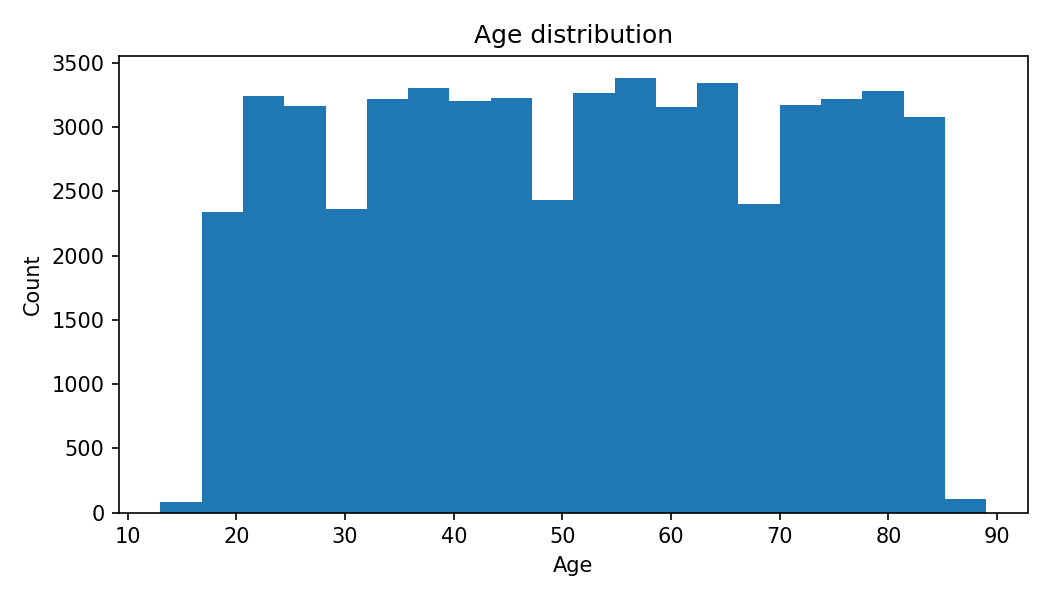

In [7]:
from IPython.display import Image, display

display(Image("/kaggle/working/outputs/age_distribution.png"))


In [8]:
import pandas as pd

df = pd.read_csv("/kaggle/working/outputs/Medical_Condition_counts.csv")
df.head()


,Count,count
0,Arthritis,9308
1,Diabetes,9304
2,Hypertension,9245
3,Obesity,9231
4,Cancer,9227


In [9]:
with open("/kaggle/working/outputs/model_metrics.txt") as f:
    print(f.read())


Accuracy: 0.4344

              precision    recall  f1-score   support

    Abnormal       0.43      0.45      0.44      3726
Inconclusive       0.43      0.42      0.43      3671
      Normal       0.44      0.43      0.43      3703

    accuracy                           0.43     11100
   macro avg       0.43      0.43      0.43     11100
weighted avg       0.43      0.43      0.43     11100

